# **CSC2541 Colab Assignment**
## *MAML Implementation with JAX*


# MAML

## What is Meta-Learning?
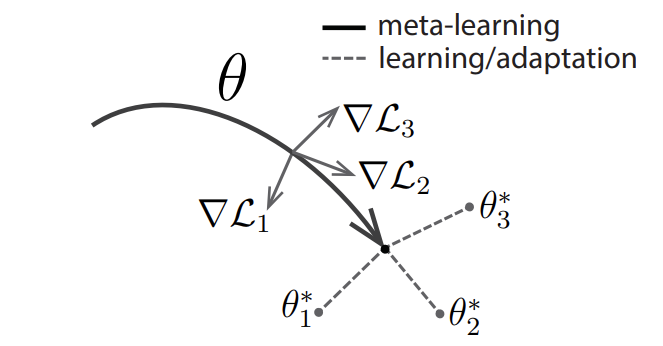

Comparing to fine-tune method, meta-learning method learns from different tasks, and optimize to an equlibrium point that considers all tasks.

So if there is a new task, meta-learning method will fast adaptive to the new task in (ideally) few steps.

## MAML Algorithm

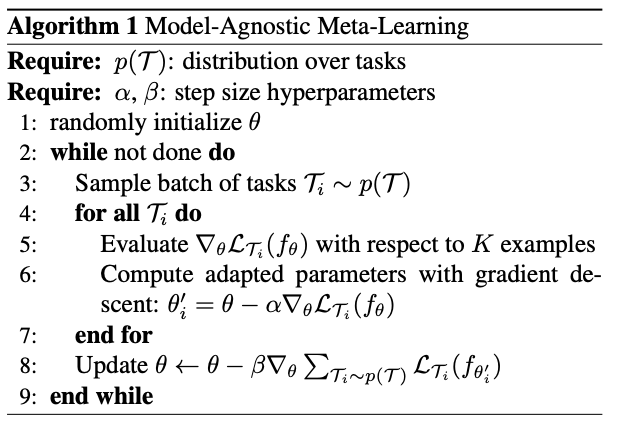

# Enviroment

In [ ]:
!pip install jax
!pip install torchmeta
!pip install numpy
!pip install torch
!pip install PyYAML
!pip install opencv-python

In [ ]:
from torchmeta.datasets.helpers import omniglot
from torchmeta.utils.data import BatchMetaDataLoader
import jax.numpy as jnp
from jax import grad, jit, random, vmap
from jax.experimental import stax
from jax.experimental.stax import Conv, Dense, MaxPool, Relu, Tanh, Flatten, BatchNorm, LogSoftmax # neural network layers
import matplotlib.pyplot as plt
from jax.experimental import optimizers
from jax.tree_util import tree_multimap
import jax
import yaml
import os
import torch
import cv2
import numpy as onp
from tqdm import tqdm
import pickle
from functools import partial
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


# **Case Study 1: Classification**



## Backbone Model (Feature Extractor)

In [ ]:
hidden_unit = 64
out_channel = 5
net_init, net_apply = stax.serial(
                                        Conv(
                                            hidden_unit, (3, 3),
                                            strides=(1, 1),
                                            padding=[(1, 1), (1, 1)]
                                        ),
                                        BatchNorm(),
                                        Relu,MaxPool
                                        MaxPool(
                                            (2, 2),
                                            strides=(2, 2),
                                            padding="SAME",

                                        ),


                                        Conv(
                                            hidden_unit, (3, 3),
                                            strides=(1, 1),
                                            padding=[(1, 1), (1, 1)]

                                        ),
                                        BatchNorm(),
                                        Relu,
                                        MaxPool(
                                            (2, 2),
                                            strides=(2, 2),
                                            padding="SAME",

                                        ),


                                        Conv(
                                            hidden_unit, (3, 3),
                                            strides=(1, 1),
                                            padding=[(1, 1), (1, 1)]
                                        ),
                                        BatchNorm(),
                                        Relu,
                                        MaxPool(
                                            (2, 2),
                                            strides=(2, 2),
                                            padding="SAME",

                                        ),


                                        Conv(
                                            hidden_unit, (3, 3),
                                            strides=(1, 1),
                                            padding=[(1, 1), (1, 1)]

                                        ),
                                        BatchNorm(),
                                        Relu,
                                        MaxPool(
                                            (2, 2),
                                            strides=(2, 2),
                                            padding="SAME",

                                        ),

                                        Flatten,
                                        Dense(out_channel),
                                        LogSoftmax,
        )
opt_init, opt_update, get_params = optimizers.adam(step_size=1e-3)
alpha = 0.1

## Helper Functions

In [ ]:
def get_sample_image(way_num, support_inputs, query_inputs, support_targets, query_targets, save_dir, step):
    # only support episode number = 1
    assert support_inputs.shape[0] == query_inputs.shape[0] == support_targets.shape[0] == query_targets.shape[0]
    os.makedirs(save_dir, exist_ok=True)
    # (5, 28, 28, 1)
    support_data_permute = support_inputs.permute(0, 1, 3, 4, 2).squeeze(0)
    # (75, 28, 28, 1)
    query_data_permute = query_inputs.permute(0, 1, 3, 4, 2).squeeze(0)

    support_data_reshape = torch.reshape(support_data_permute, (way_num, -1, *support_data_permute.shape[1:]))
    query_data_reshape = torch.reshape(query_data_permute, (way_num, -1, *query_data_permute.shape[1:]))
    device = support_inputs.get_device()
    # (5, 1+15, 28, 28, 1)
    black = torch.zeros(support_data_reshape.shape[0], 1, *support_data_reshape.shape[-3:]) + 1
    black = black.cuda() if device != -1 else black
    complete_tensor = torch.cat([support_data_reshape, black, query_data_reshape], dim=1)
    present_list = []
    for row in complete_tensor:
        tensor_list = [tensor for tensor in row]
        tensor_row = torch.cat(tensor_list, dim=1)
        present_list.append(tensor_row)
    present_tensor = torch.cat(present_list, dim=0)
    img = present_tensor.cpu().numpy() * 255
    img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    cv2.imwrite(os.path.join(save_dir, 'sampled_image_{}.png'.format(step)), img)


def torch2jnp(support_inputs, query_inputs, support_targets, query_targets):
    assert support_inputs.shape[0] == query_inputs.shape[0] == support_targets.shape[0] == query_targets.shape[0]
    support_inputs = jnp.array(support_inputs.squeeze(0).permute(0, 2, 3, 1).cpu().detach().numpy())
    query_inputs = jnp.array(query_inputs.squeeze(0).permute(0, 2, 3, 1).cpu().detach().numpy())
    support_targets = jnp.array(support_targets.squeeze(0).cpu().detach().numpy())
    query_targets = jnp.array(query_targets.squeeze(0).cpu().detach().numpy())
    return support_inputs, query_inputs, support_targets, query_targets

## MAML Core Functions

In [ ]:
# Algo2, based on line 7
def inner_update(p, x1, y1):
    grads = grad(loss)(p, x1, y1)
    inner_sgd_fn = lambda g, state: (state - alpha*g)
    # Element-wise manipulation of collections of numpy arrays
    return tree_multimap(inner_sgd_fn, grads, p)

def loss(params, inputs, targets, not_grad=False):
    # Computes average loss for the batch
    predictions = net_apply(params, inputs)
    targets_one_hot = jax.nn.one_hot(targets, predictions.shape[1])
    ce_loss = -jnp.mean(jnp.sum(predictions * targets_one_hot, axis=1))
    acc = onp.sum(jnp.argmax(predictions, 1) == targets) / len(targets)

    if not_grad:
        return ce_loss, acc
    else:
        return ce_loss

# Algo2, based on line 10
def maml_loss(p, support_data, support_label, query_data, query_label, not_grad=False):
    # inner loop, use support set to perform inner update
    p2 = inner_update(p, support_data, support_label)
    # outer loop, use query set to perform meta update
    total_loss, acc = loss(p2, query_data, query_label, not_grad=True)

    if not_grad:
        return total_loss, acc
    else:
        return total_loss

# pytorch forward-like function 
@jit
def step(i, opt_state, support_data, support_label, query_data, query_label):
    params = get_params(opt_state)
    grads = grad(maml_loss)(params, support_data, support_label, query_data, query_label)
    loss, acc = maml_loss(params, support_data, support_label, query_data, query_label, not_grad=True)
    if i is not None:
        return opt_update(i, grads, opt_state), loss, acc
    else:
        return loss, acc

In [ ]:
def train(config, train_dataloader, val_dataloader, ckpt_file_name):
    # set up
    rng = random.PRNGKey(config["seed"])
    in_shape = (-1, config["shape"][0], config["shape"][1], config["shape"][2])
    best_val_acc = 0
    best_val_acc_std = 0
    out_shape, net_params = net_init(rng, in_shape)
    opt_state = opt_init(net_params)
    train_losses = []
    train_accs = []
    val_x = []
    val_accs = []
    val_losses = []
    sampled_interval = config["total_train_iter"] // 10
    
    # main loop
    for train_iter_count in tqdm(range(config["total_train_iter"])):
        train_batch = next(iter(train_dataloader))
        train_support_inputs, train_support_targets = train_batch["train"]
        train_query_inputs, train_query_targets = train_batch["test"]

        # sampling some snapshots
        if train_iter_count % sampled_interval == 0:
            get_sample_image(config["N"], train_support_inputs, train_query_inputs, train_support_targets,
                             train_query_targets, config["ckpt_path"], train_iter_count)

        train_support_inputs, train_query_inputs, train_support_targets, train_query_targets = \
            torch2jnp(train_support_inputs, train_query_inputs, train_support_targets, train_query_targets)

        # like pytorch forward method
        opt_state, train_loss, train_acc = step(train_iter_count, opt_state, train_support_inputs, train_support_targets, train_query_inputs , train_query_targets)
        train_accs.append(train_acc)
        train_losses.append(train_loss)

        # validation process
        if train_iter_count % config["val_interval"] == 0 and train_iter_count > 0:
            val_accs_local = []
            val_losses_local = []
            for _ in range(config["val_size"]):
                val_batch = next(iter(val_dataloader))
                val_support_inputs, val_support_targets = val_batch["train"]
                val_query_inputs, val_query_targets = val_batch["test"]
                val_support_inputs, val_query_inputs, val_support_targets, val_query_targets = \
                    torch2jnp(val_support_inputs, val_query_inputs, val_support_targets, val_query_targets)
                val_loss, val_acc = step(None, opt_state, val_support_inputs, val_support_targets, val_query_inputs , val_query_targets)
                val_accs_local.append(val_acc)
                val_losses_local.append(val_loss)
            val_acc_mean = onp.mean(onp.array(val_accs_local))
            val_acc_std = onp.std(onp.array(val_accs_local))
            val_loss_mean = onp.mean(onp.array(val_losses_local))

            print("average validation accuracy at: {}, mean: {}, std: {}".format(train_iter_count, val_acc_mean, val_acc_std))
            if val_acc_mean > best_val_acc:
                best_val_acc = val_acc_mean
                best_val_acc_std = val_acc_std
                trained_params = optimizers.unpack_optimizer_state(opt_state)
                with open(os.path.join(config["ckpt_path"], ckpt_file_name), "wb") as ckpt:
                    pickle.dump(trained_params, ckpt)
                ckpt.close()
                print("best validation ckpt saved")
            val_x.append(train_iter_count)
            val_accs.append(val_acc_mean)
            val_losses.append(val_loss_mean)

    # Plots
    plt.plot(onp.arange(config["total_train_iter"]), train_losses, label='train loss', alpha=0.5)
    plt.plot(val_x, val_losses, label='val loss')
    plt.legend(loc="best")
    plt.savefig(os.path.join(config["ckpt_path"], "./maml_jax_loss.png"))
    plt.close()
    plt.plot(onp.arange(config["total_train_iter"]), train_accs, label='train accuracy', alpha=0.5)
    plt.plot(val_x, val_accs, label='val accuracy')
    plt.legend(loc="best")
    plt.savefig(os.path.join(config["ckpt_path"], "./maml_jax_acc.png"))
    print("best validation accuracy: {}, std: {}".format(best_val_acc, best_val_acc_std))

In [ ]:
def test(config, test_dataloader, ckpt_file_name):
    # load from checkpoint
    best_params = pickle.load(open(os.path.join(config["ckpt_path"], ckpt_file_name), "rb"))
    best_opt_state = optimizers.pack_optimizer_state(best_params)
    print()
    print("best ckpt loaded")
    test_accs_local = []
    test_losses_local = []
    for _ in range(config["test_size"]):
        test_batch = next(iter(test_dataloader))
        test_support_inputs, test_support_targets = test_batch["train"]
        test_query_inputs, test_query_targets = test_batch["test"]
        test_support_inputs, test_query_inputs, test_support_targets, test_query_targets = \
            torch2jnp(test_support_inputs, test_query_inputs, test_support_targets, test_query_targets)
        test_loss, test_acc = step(None, best_opt_state, test_support_inputs, test_support_targets, test_query_inputs,
                                 test_query_targets)
        test_accs_local.append(test_acc)
        test_losses_local.append(test_loss)
    test_acc_mean = onp.mean(onp.array(test_accs_local))
    test_acc_std = onp.std(onp.array(test_accs_local))
    test_loss_mean = onp.mean(onp.array(test_losses_local))
    print("test accuracy: {}, std: {}".format(test_acc_mean, test_acc_std))
    print("test loss: {}".format(test_loss_mean))
    print()

## Set Up

In [ ]:
cd /content/drive/MyDrive/Colab\ Notebooks

/content/drive/MyDrive/Colab Notebooks


In [ ]:
ls

 colourization.ipynb            ml_assignment.ipynb
 colour_regression.ipynb        nmt.ipynb
 config.yaml                   'Python_Warmup (1).ipynb'
'Copy of moco_cifar10_demo'    'Python_Warmup (2).ipynb'
 cycle_gan.ipynb                Python_Warmup.ipynb
 data/                         'rs_assignment (1).ipynb'
 ir_assignment.ipynb           'rs_assignment (2).ipynb'
 lab_ml.ipynb                  'rs_assignment (3).ipynb'
 lab_rs.ipynb                   rs_assignment_check_global.ipynb
 ml_assignment_50trails.ipynb   rs_assignment_check.ipynb
 ml_assignment-77.04.ipynb      rs_assignment.ipynb
 ml_assignment_79.85.ipynb      rs_assignment_non_pop.ipynb
 ml_assignment_79.95.ipynb      rs_assignment_non_scale.ipynb
 ml_assignment_backup.ipynb     rs_assignment_vanilla.ipynb


In [ ]:
import os
if not os.path.exists('data/omniglot'):
   os.makedirs('data/omniglot')
if not os.path.exists('result_files/'):
   os.makedirs('result_files/')

In [ ]:
config = yaml.load(open("./config.yaml"), Loader=yaml.Loader)

# change download to False when finished downloading
train_dataset = omniglot("data", ways=config["N"], shots=config["K"], test_shots=config["Q"], meta_train=True, download=False)
val_dataset = omniglot("data", ways=config["N"], shots=config["K"], test_shots=config["Q"], meta_val=True, download=False)
test_dataset = omniglot("data", ways=config["N"], shots=config["K"], test_shots=config["Q"], meta_test=True, download=False)

train_dataloader = BatchMetaDataLoader(train_dataset, batch_size=config["batch_size"], num_workers=0)
val_dataloader = BatchMetaDataLoader(val_dataset, batch_size=config["batch_size"], num_workers=0)
test_dataloader = BatchMetaDataLoader(test_dataset, batch_size=config["batch_size"], num_workers=0)

In [ ]:
# ckpt_file_name = "best_ckpt_small.pkl"
ckpt_file_name = "best_ckpt.pkl"

## Example of an Episode

### 5way-1shot-15query

Left Block: Support Set, Right Block: Query Set

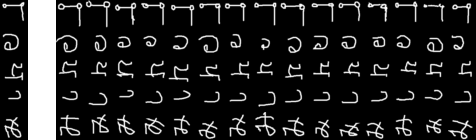

## Train and Inference

### Train and Validation

In [ ]:
train(config, train_dataloader, val_dataloader, ckpt_file_name)

Loss Curve:

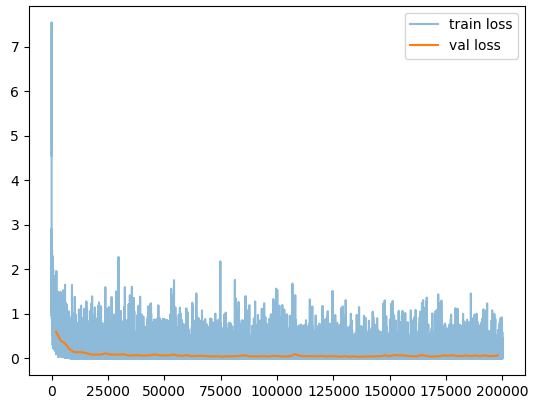

Accuracy Curve:

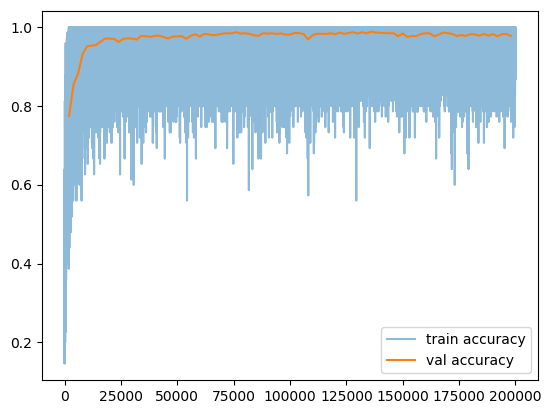

### Inference

In [ ]:
test(config, test_dataloader, ckpt_file_name)


best ckpt loaded


/usr/local/lib/python3.7/dist-packages/torchvision/transforms/functional.py:943: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "


test accuracy: 0.9880000352859497, std: 0.015143741853535175
test loss: 0.03949246555566788





# **Case Study 2: Cosine Regression**



## Backbone

In [ ]:
# Use stax to set up network initialization and evaluation functions
cosine_init, cosine_model = stax.serial(
    Dense(40), 
    Tanh,
    Dense(40), 
    Tanh,
    Dense(1)
    )
in_shape = (-1, 1)

## Set Up

In [ ]:
K = 100
total_step = 50000
alpha = 0.2
x_low = -10
x_high = 10
amplitude_low = 0.1
amplitude_high = 1
phase_low = 0
phase_high = onp.pi/2
onp.random.seed(0)

X = onp.linspace(x_low, x_high, K).reshape((K, 1))

opt_init, opt_update, get_params = optimizers.adam(step_size=1e-3)  # this LR seems to be better than 1e-2 and 1e-4
out_shape, net_params = cosine_init(random.PRNGKey(0), in_shape)
opt_state = opt_init(net_params)

## Helper Function

In [ ]:
@jit
def cos_step(i, opt_state, inner_x, inner_y, outer_x, outer_y):
    params = get_params(opt_state)
    gradient = grad(cos_maml_loss)(params, inner_x, inner_y, outer_x, outer_y)
    loss = cos_maml_loss(params, inner_x, inner_y, outer_x, outer_y)
    return opt_update(i, gradient, opt_state), loss

# Algo2, based on line 7
def cos_inner_update(params, inner_x, inner_y):
    grads = grad(mse_loss)(params, inner_x, inner_y)
    inner_sgd_fn = lambda gradient, state: (state - alpha * gradient)
    # Element-wise manipulation
    return tree_multimap(inner_sgd_fn, grads, params)

def mse_loss(params, inputs, targets):
    predictions = cosine_model(params, inputs)
    return onp.mean((targets - predictions)**2)

# Algo2, based on line 10
def cos_maml_loss(p, inner_x, inner_y, outer_x, outer_y, ):
    # Default to be 1 inner loop
    # inner loop, use support set to perform inner update
    p2 = cos_inner_update(p, inner_x, inner_y)
    # outer loop, use query set to perform meta update
    total_loss = mse_loss(p2, outer_x, outer_y)
    return total_loss

## Main Training Loop

In [ ]:
loss_list = []

for i in range(total_step):
    amplitude = onp.random.uniform(low=amplitude_low, high=amplitude_high)
    phase = onp.random.uniform(low=phase_low, high=phase_high)
    # meta-training inner samples (K examples)
    inner_x = onp.random.uniform(low=x_low, high=x_high, size=(K, 1))
    inner_y = amplitude * onp.cos(inner_x + phase)

    # meta-training outer sample (1 example).
    outer_x = onp.random.uniform(low=x_low, high=x_high)
    outer_y = amplitude * onp.cos(outer_x + phase)

    opt_state, loss = cos_step(i, opt_state, inner_x, inner_y, outer_x, outer_y)
    loss_list.append(loss)
    if (i + 1) % 5000 == 0:
        print(i + 1)

net_params = get_params(opt_state)

Text(0.5, 1.0, 'training loss for regression')

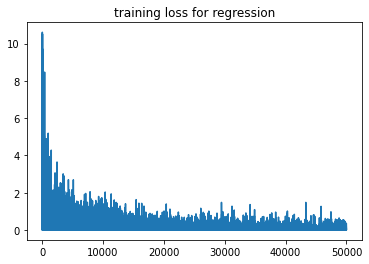

In [ ]:
plt.plot(loss_list)
plt.title("training loss for regression")

Text(0.5, 1.0, 'Target Cosine Function: 0.554 * cos ( x + 1.146 )')

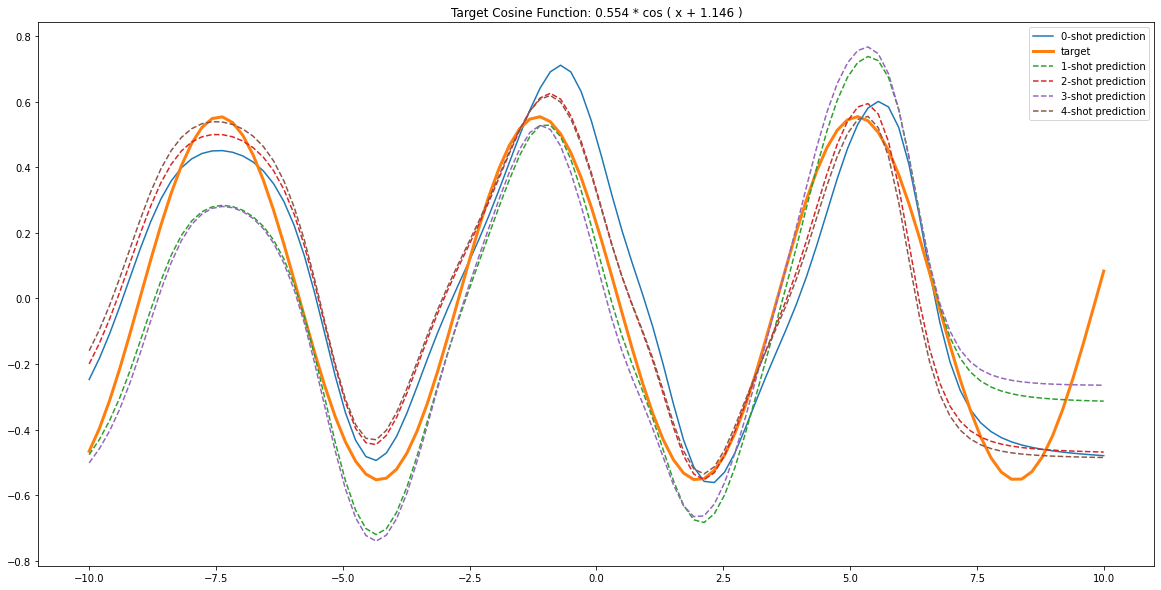

In [ ]:
plt.figure(figsize=(20, 10))

# another task, to verify quick adaption
amplitude_new = onp.random.uniform(low=amplitude_low, high=amplitude_high)
phase_new = onp.random.uniform(low=phase_low, high=phase_high)
y_new = amplitude_new * onp.cos(X + phase_new)

predictions_maml_0 = vmap(partial(cosine_model, net_params))(X)
plt.plot(X, predictions_maml_0, label='0-shot prediction')
plt.plot(X, y_new, label='target', linewidth=3)

for i in range(1, 5):
    net_params = cos_inner_update(net_params, X, y_new)
    predictions_maml = vmap(partial(cosine_model, net_params))(X)
    plt.plot(X, predictions_maml, label='{}-shot prediction'.format(i), linestyle='--')
plt.legend()
plt.title('Target Cosine Function: {0:1.3f} * cos ( x + {1:1.3f} )'.format(amplitude_new, phase_new))

## Regular Model (No Meta-learning)

5000
10000
15000
20000
25000
30000
35000
40000
45000
50000


Text(0.5, 1.0, 'training loss for regular regression')

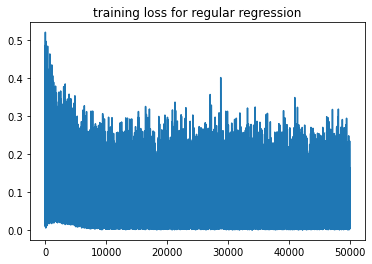

In [ ]:
def mse_loss_regular(params, inputs, targets):
    predictions = cosine_model(params, inputs)
    return onp.mean((targets - predictions)**2)

@jit
def regular_step(i, opt_state_regular, X_regular, y_regular):
    params_regular = get_params(opt_state_regular)
    gradient_regular = grad(mse_loss_regular)(params_regular, X_regular, y_regular)
    loss_regular = mse_loss_regular(params_regular, X_regular, y_regular)
    return opt_update(i, gradient_regular, opt_state_regular), loss_regular


loss_list_regular = []
opt_state_regular = opt_state
for i in range(total_step):
    amplitude_regular = onp.random.uniform(low=amplitude_low, high=amplitude_high)
    phase_regular = onp.random.uniform(low=phase_low, high=phase_high)
    X_regular = onp.random.uniform(low=x_low, high=x_high, size=(K, 1))
    y_regular = amplitude_regular * onp.cos(X_regular + phase_regular)
    opt_state_regular, loss_regular = regular_step(i, opt_state_regular, X_regular, y_regular)
    loss_list_regular.append(loss_regular)
    if (i + 1) % 5000 == 0:
        print(i + 1)
net_params_regular = get_params(opt_state_regular)
plt.plot(loss_list_regular)
plt.title("training loss for regular regression")

200
400
600
800
1000


Text(0.5, 1.0, 'Target Cosine Function: 0.759 * cos ( x + 0.370 )')

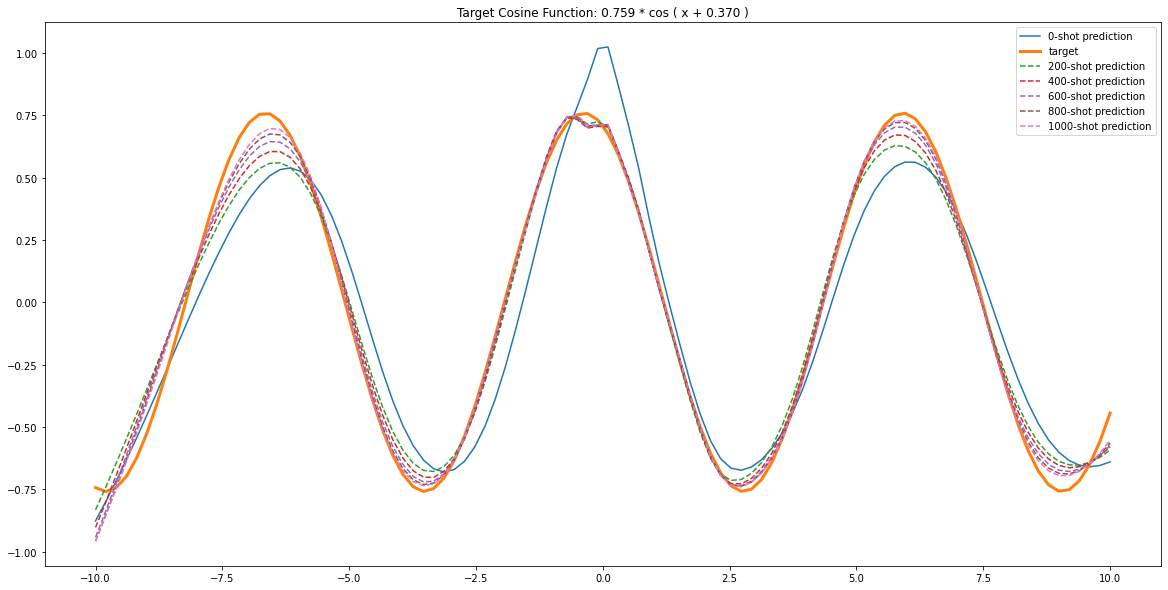

In [ ]:
plt.figure(figsize=(20, 10))

# another task, to verify quick adaption
amplitude_new_regular = onp.random.uniform(low=amplitude_low, high=amplitude_high)
phase_new_regular = onp.random.uniform(low=phase_low, high=phase_high)
y_new_regular = amplitude_new_regular * onp.cos(X + phase_new_regular)

predictions_regular_0 = vmap(partial(cosine_model, net_params_regular))(X)
plt.plot(X, predictions_regular_0, label='0-shot prediction')
plt.plot(X, y_new_regular, label='target', linewidth=3)

for i in range(1, 1000):
    net_params_regular = get_params(opt_state_regular)
    opt_state_regular, loss_regular = regular_step(i, opt_state_regular, X, y_new_regular)
    predictions_regular = vmap(partial(cosine_model, net_params_regular))(X)
    if (i + 1) % 200 == 0:
        print(i + 1)
        plt.plot(X, predictions_regular, label='{}-shot prediction'.format(i + 1), linestyle='--')

plt.legend()
plt.title('Target Cosine Function: {0:1.3f} * cos ( x + {1:1.3f} )'.format(amplitude_new_regular, phase_new_regular))

# Improvement of MAML

## Stabilizing MAML: Multi-Step Loss Optimization (MSL) from MAML++

N gradient steps for each task when training, to compare:
*   calculate outer loop loss at every step (MAML++)
*  calculate outer loop loss after N step (MAML)

We used N=2 and train 5000 epochs for simplicity.

In [ ]:
# Implement the Multi-Step Loss Optimization (MSL) of MAML++ https://arxiv.org/abs/1810.09502
def maml_loss_multistep(p, x1, y1, x2, y2, not_grad=False, multi_step=True):

    p_cur = p
    steps_loss = []
    for num_step in range(2):
        p_cur = inner_update(p_cur, x1, y1)

        if multi_step:
            step_loss, acc = loss(p_cur, x2, y2, not_grad=True)
            steps_loss.append(step_loss)
        else:
            if num_step == 1:
                step_loss, acc = loss(p_cur, x2, y2, not_grad=True)
                steps_loss.append(step_loss)

    # total_loss, acc = loss(p_cur, x2, y2, not_grad=True)
    total_loss = jnp.sum(jnp.array(steps_loss))
    if not_grad:
        return total_loss, acc
    else:
        return total_loss

Validation accuracy during training:

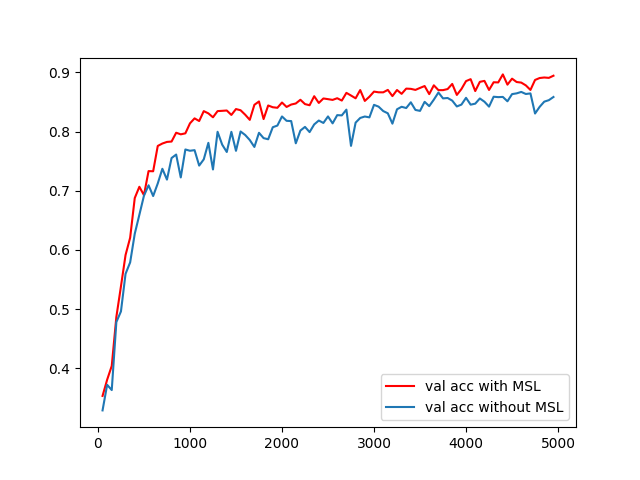

<!-- ## Reduce Computation Cost: Derivative-Order Aneealing (DA)

Use first-order gradients for the first 50 epochs of the training phase, and then switch to second_order gradients for the remainder of the training phase. -->

## Reptile: First Order Approximation

In [ ]:
def reptile_update(p, x, y):
    grads = grad(ce_loss)(p, x, y)
    inner_sgd_fn = lambda g, state: (state - alpha*g)
    # Element-wise manipulation of collections of numpy arrays
    return tree_multimap(inner_sgd_fn, grads, p)


def ce_loss(params, inputs, targets, not_grad=False):
    # Computes average loss for the batch
    predictions = net_apply(params, inputs)
    targets_one_hot = jax.nn.one_hot(targets, predictions.shape[1])
    ce_loss = -jnp.mean(jnp.sum(predictions * targets_one_hot, axis=1))
    acc = onp.sum(jnp.argmax(predictions, 1) == targets) / len(targets)

    if not_grad:
        return ce_loss, acc
    else:
        return ce_loss


def reptile_loss(p, x1, y1, x2, y2, epsilon, i=1, is_train=True):

    if is_train:
        # stack support and query data alone instance number axis (1 + 15)
        combined_x = jnp.concatenate([x1, x2], 0)
        combined_y = jnp.concatenate([y1, y2], 0)

        p2 = reptile_update(p, combined_x, combined_y)
        if i > 1:
            for _ in range(i - 1):
                p2 = reptile_update(p2, combined_x, combined_y)

        total_loss, acc = ce_loss(p2, combined_x, combined_y, not_grad=True)

        return total_loss, acc, param_opreation(p2, p, epsilon, "substract")

    else:
        p2 = reptile_update(p, x1, y1)
        if i > 1:
            for _ in range(i - 1):
                p2 = reptile_update(p2, x1, y1)

        total_loss, acc = ce_loss(p2, x2, y2, not_grad=True)

        return total_loss, acc


def param_opreation(p1, p2, epsilon, opreation):
    # Could be optimized
    assert len(p1) == len(p2)
    result_list = []
    i = 0
    while i < len(p1):
        p1_i = p1[i]
        p2_i = p2[i]
        if len(p1_i) != 0 and len(p2_i) != 0:
            p_i0 = jnp.subtract(p1_i[0], p2_i[0]) * epsilon * -1
            p_i1 = jnp.subtract(p1_i[1], p2_i[1]) * epsilon * -1
            result_list.append((p_i0, p_i1))
        else:
            result_list.append(())
        i += 1

    return result_list


@jax.jit
def reptile_step(i, opt_state, x1, y1, x2, y2):
    episode_num = x1.shape[0]
    accs = []
    ls = []
    epsilon = 1e-3
    p = get_params(opt_state)
    if i is not None:
        l, acc,  results = reptile_loss(p, x1, y1, x2, y2, epsilon)
        return opt_update(i, results, opt_state), ls, accs
    else:
        l, acc = reptile_loss(p, x1, y1, x2, y2, epsilon, is_train=False)
        return ls, accs


def mock_reptile_train(train_dataloader):
    rng = random.PRNGKey(0)
    in_shape = (-1, 28, 28, 1)
    best_val_acc = 0
    best_val_acc_std = 0
    out_shape, net_params = net_init(rng, in_shape)
    opt_state = opt_init(net_params)
    for train_iter_count in tqdm(range(100)):
        train_batch = next(iter(train_dataloader))
        train_support_inputs, train_support_targets = train_batch["train"]
        train_query_inputs, train_query_targets = train_batch["test"]
        train_support_inputs, train_query_inputs, train_support_targets, train_query_targets = \
            torch2jnp(train_support_inputs, train_query_inputs, train_support_targets, train_query_targets)
        opt_state, train_loss, train_acc = reptile_step(train_iter_count, opt_state, train_support_inputs, train_support_targets, train_query_inputs , train_query_targets)


def mock_maml_train(train_dataloader):
    rng = random.PRNGKey(0)
    in_shape = (-1, 28, 28, 1)
    best_val_acc = 0
    best_val_acc_std = 0
    out_shape, net_params = net_init(rng, in_shape)
    opt_state = opt_init(net_params)
    for train_iter_count in tqdm(range(100)):
      train_batch = next(iter(train_dataloader))
      train_support_inputs, train_support_targets = train_batch["train"]
      train_query_inputs, train_query_targets = train_batch["test"]
      train_support_inputs, train_query_inputs, train_support_targets, train_query_targets = \
          torch2jnp(train_support_inputs, train_query_inputs, train_support_targets, train_query_targets)
      opt_state, train_loss, train_acc = step(train_iter_count, opt_state, train_support_inputs, train_support_targets, train_query_inputs , train_query_targets)


Accuracy Curve

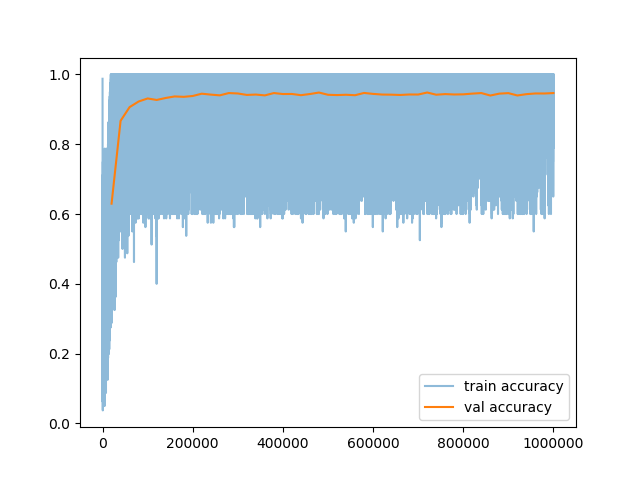

In [ ]:
%timeit mock_maml_train(train_dataloader)

  0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torchvision/transforms/functional.py:943: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "
100%|██████████| 100/100 [00:04<00:00, 24.26it/s]

The slowest run took 12.41 times longer than the fastest. This could mean that an intermediate result is being cached.
1 loop, best of 5: 4.18 s per loop


In [ ]:
%timeit mock_reptile_train(train_dataloader)

  0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torchvision/transforms/functional.py:943: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "
100%|██████████| 100/100 [00:03<00:00, 25.84it/s]

1 loop, best of 5: 3.9 s per loop
